In [106]:
# mesa imports
from mesa_geo import GeoAgent, GeoSpace
from mesa.time import BaseScheduler, RandomActivation, SimultaneousActivation
from mesa import datacollection
from mesa import Model

# language model imports
import re
import torch
from transformers import pipeline
import networkx as nx
import openai

# shapely imports
from shapely.geometry import Polygon, Point, LineString
import shapely

# data analysis imports
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import copy
import time

# plotting imports
import matplotlib as plt

In [2]:
language_model = pipeline(model="declare-lab/flan-alpaca-xl", device="cuda:0")

key_path = "openai_api_key"
#openai.organization = "org-D3T7qkglEsZGgYNCoTz3Uocx"
with open(key_path, "r") as f:
    api_key = f.readline()
openai.api_key = api_key

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
sd_cities = """
Alpine
Bonita
Bonsall
Borrego Springs
Boulevard
Camp Pendleton
Campo
Cardiff By The Sea
Carlsbad
Chula Vista
Coronado
Del Mar
Descanso
Dulzura
El Cajon
Encinitas
Escondido
Fallbrook
Guatay
Imperial Beach
Jacumba
Jamul
Julian
La Jolla
La Mesa
Lakeside
Lemon Grove
Mount Laguna
National City
Oceanside
Pala
Palomar Mountain
Pauma Valley
Pine Valley
Potrero
Poway
Ramona
Ranchita
Rancho Santa Fe
San Diego
San Luis Rey
San Marcos
San Ysidro
Santa Ysabel
Santee
Solana Beach
Spring Valley
Tecate
Valley Center
Vista
Warner Springs
"""

In [4]:
sd_cities = sd_cities.split()

In [5]:
agent_N = 10
agent_age = np.random.choice(np.arange(6,30), agent_N)
agent_gender = np.random.choice(['male', 'female'], agent_N)
agent_home = np.random.choice(sd_cities, agent_N)

synthatic_background = pd.DataFrame({'age': agent_age,
                    'gender': agent_gender,
                    'home': agent_home})

In [6]:
synthatic_background

,age,gender,home
0,17,male,Diego
1,11,female,Julian
2,11,female,Valley
3,13,male,Oceanside
4,14,female,Lemon
5,18,female,Rey
6,18,female,Campo
7,7,male,Palomar
8,8,male,El
9,26,male,Jacumba


In [145]:
class Human(GeoAgent):
    '''
    A simple geo-agent that each step moves in the range of [-5,5) and greets all agents within 2 units
    unique_id: the unique_id of the agent
    model: the model that the agent belongs to
    shape: the spatial shape of the agent
    '''
    def __init__(self, unique_id, model, shape, agent_background, crs=3857):
        super().__init__(unique_id, model, shape, crs)
        self.greeted = False # some attribute to indicate if one agent has ever greeted another agent in its life-span
        
        # coordinate attributes
        # eventhough it is not ncessary to establish as attributes
        # setting as attribute would enhance data collection efficiency
        # check mesa documentation for more details in the DataCollector page
        self.x = self.geometry.x
        self.y = self.geometry.y
        
        # set up interaction background for language model
        self.background = agent_background
        self.room = None
        
        
        #dummy greeting distance for agents
        self.greet_dist = 4
        
    
        
    def move(self, other_agent=None, move_range=1):
        '''
        update the current location 
        if other_agent is provided agent will move toward the other agent
        else, the agent will move within the random range and greet to all surrounding neighbors with specified greet_dist
        '''
        

        if other_agent:    
            self.update_shape(other_agent.geometry)
        
        
        move_spread = self.room.geometry.intersection(self.geometry.buffer(move_range))
        

        minx, miny, maxx, maxy = move_spread.bounds 

        while True:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))            
            # check if point lies in true area of polygon
            if move_spread.contains(pnt):
                self.update_shape(pnt)
                break

    
    def update_shape(self, new_shape):
        self.geometry = new_shape
        self.x = self.geometry.x
        self.y = self.geometry.y
    
    def step(self):
        
        if self.model.schedule_type != "Simultaneous":
            self.advance()
    
    def advance(self):
        # greet near by agents 
        
        neighbors = self.model.grid.get_neighbors_within_distance(self, self.greet_dist)
        neighbors = [neighbor for neighbor in neighbors if neighbor.unique_id != self.unique_id]
        
        for neighbor in neighbors:
            if issubclass(type(neighbor), Human):
                print('Hi! Fellow agent ' + str(neighbor.unique_id) + ". I am " + str(self.unique_id))
            
        
          
    
    

    

In [146]:
def generate_text(prompt_background, prompt_text, use_openai = False):
    if use_openai:
        print("using openai gpt-3.5-turbo")
        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
            {"role": "system", "content": prompt_background},
            {"role": "user", "content": prompt_text}
            ]
            )

        return completion.choices[0].message['content']
    else:
        # merge background and question for simple model
        prompt = prompt_background + prompt_text
        return language_model(prompt, do_sample=True, min_length=10, max_length=len(prompt)+128)[0]["generated_text"]

In [186]:
class Room(GeoAgent):
    
    
    # dummy config for data collection
    health_status = None
    symptoms = None
    x = None
    y = None
    
    
    def __init__(self, unique_id, model, shape, room_type, crs=3857):
        super().__init__(unique_id, model, shape, crs)
        #self.occupants = []
        #self.aerosol_transmission_rate = []
        #self.barrier = barrier_type
        self.room_type = room_type
        #self.seating_pattern = None
        #self.viral_load = 0
        #self.schedule_id = None
        self.activity = "social gathering event"
        
        # volume
        #self.floor_area = shape.area
        #self.height = 12

        # airflow ventiliation type
        #self.environment = eval(school_intervention_params['ventilation_type'])
    
    def step(self):
        #reset location of agents within the room:
        occupants = [a for a in list(self.model.grid.get_intersecting_agents(self)) if issubclass(type(a), Human)]
        for a in occupants:
            a.move(move_range=10)
        
            
        
        occupant_ids = [a.unique_id for a in occupants]
        #exposed = [a for a in occupants if a.infective]

        num_occupants = len(occupants)
        #num_exposed = len(exposed)

        # assume this is a cafe for now

        prompt = "There are {} people in this location.".format(num_occupants)

        prompt += ' Currently it is {}.'.format(self.model.time)

        agent_descriptions = [f"{agent.unique_id}: {agent.description}" for agent in occupants]
        prompt += ' We know the following about people: ' + '. '.join(agent_descriptions)

        #agent_plans = [f"{agent.unique_id}: {agent.plan}" for agent in self.schedule.agents]
        #prompt += ' We know the daily plan about people: '+ '. '.join(agent_plans)

        prompt += 'They can interact with each other. '

        prompt += "What will each person do in the next hour? Use at most 10 words for each person. Choose one action for each person"
        
        action_text = generate_text("This is a {}. Currently there is a {} happening in this room".format(self.room_type, self.activity), prompt, use_openai=True)
        
        print(action_text)
        
        
        action_lst = re.split(r'p[0-9]+: ', action_text)[1:]
        action_ids = copy.deepcopy(occupant_ids)
        
        for i in range(len(action_lst)):
            act = action_lst[i]
            # let language model to decide who is having social interaction
            print(act)
            action_bool = generate_text("", "Is there social interaction happening in the action: {} Answer only Yes or No.".format(act))

            if 'No' in action_bool:
                if occupant_ids[i] in action_ids:
                    action_ids.remove(occupant_ids[i])
                
                print('No social interaction for this person!')
                continue
            # if no available actable agents, end loop
            if len(action_ids) == 0:
                break
            actor_id = occupant_ids[i]
            prompt = "The action of {} is: {}. Out of {}, who are interacting with {}. Choose one person.".format(actor_id, 
                                                                                 act, 
                                                                                 ' '.join(action_ids), 
                                                                                 actor_id)

            # let language model decide the actors in this action
            actors_text = generate_text("", prompt)
            
            print("THE ACTORS ARE: ")
            agent_ids = re.findall(r'p[0-9]+', actors_text)
            for agent_id in agent_ids:
                if agent_id in action_ids:
                    action_ids.remove(agent_id)
              
    
            # if more than one agent in action text
            # bring them together physically
            print(agent_ids)
            if len(agent_ids) > 1:
                # get agent objects from agent_ids
                agents = [a for a in occupants if a.unique_id in agent_ids] 
                
                # move all agents to location of first agent in list
                for a in agents[1:]:
                    a.move(agents[0])
            
        if self.model.schedule_type != "Simultaneous":
            self.advance()
        
        
        
    def advance(self):
        """
            aerosal transmission model
        """
        self.model.grid._recreate_rtree() 
        print("DOING ROOM THINGS!")
        
            
        
    def generate_seats(self, N, width):
        
        self.seating_pattern = style
        self.seats = []
        shape = self.shape
        
        
        # generate grid seating that seperates each student by fixed amount

        center = shape.centroid
        md = math.ceil(N**(1/2))
        pnt = Point(center.x - width*md//2, center.y - width*md//2)
        for i in range(md):
            for j in range(md+1):
                self.seats.append(Point(pnt.x + i*width, pnt.y + j*width))


    


In [187]:

def get_agent_description_prompt(agent):
    prompt = "Your name is {}, you are a {}-years-old {} from {}, CA."
    prompt_text = "Tell me something more about yourself. Use at most 30 words to explain."
    prompt = prompt.format(agent.unique_id, 
                           agent.background['age'], 
                           agent.background['gender'], 
                           agent.background['home'])
    
    return prompt, prompt_text


def get_agent_plan_prompt(agent):


    prompt = "You are {}. The following is your description: {}"
    promp_text = " You just woke up. What is your goal for today? Write it down in an hourly basis, starting at 9:00. Write only one or two very short sentences. Be very brief. Use at most 50 words."
    prompt = prompt.format(agent.unique_id, agent.description)

    return prompt, prompt_text
    


class NaiveModel(Model):
    
    schedule_types = {"Sequential": BaseScheduler,
                  "Random": RandomActivation,
                  "Simultaneous": SimultaneousActivation}
    
    
    def __init__(self, agent_class, background_df, agent_N, schedule_type="Simultaneous"):
        '''
        initialize the model with a GeoSpace grid
        agent_class: the type of agent you want to initialize in this model
                     normally not an input parameter as models are mostly tied to specific agent types
                     here we want to reuse thi model later
        agent_N: number of agents to intialize the model with
        '''
        self.schedule_type = schedule_type
        
        # mesa required attributes
        self.running = True # determines if model should keep on running
        # should be specified to false when given conditions are met
        
        self.grid = GeoSpace() # To learn more about other type of space grid, check mesa documentation
        self.schedule = self.schedule_types[schedule_type](self) # scheduler dictates model level agent behavior, aka. step function
        # Here we are using a BaseScheduler which computes step of the agents by order
        # To learn more about other type of scheduler, check mesa documentation
        self.time_stamps = ["9:00am","10:00am","11:00am","12:00pm","1:00pm","2:00pm","3:00pm","4:00pm"]   
        
        # init agents
        coords = ((-10, -10), (-10, 10), (10, 10), (10, -10),(-10, -10))
        room_shape = Polygon(coords)
        
        room_agent = Room(model=self,
                          shape=room_shape,
                          unique_id = "r0",
                          room_type="Ball Room")
        self.grid.add_agents(room_agent)
        self.schedule.add(room_agent)
        
        for i in range(agent_N):
            pnt = Point(np.random.uniform(-10, 10), np.random.uniform(-10, 10))
            
            a = agent_class(model=self, 
                            shape=pnt, 
                            agent_background = background_df.loc[i], unique_id="p" + str(i))
            a.room = room_agent
            
            
            # format prompts for language model
            prompt_background, prompt_text = get_agent_description_prompt(a)
            # generate text
            # add text to agent 
            a.description = generate_text(prompt_background, prompt_text)
            self.grid.add_agents(a)
            self.schedule.add(a)
            
        # generate agent description and plan
        


            
        # do the above for plan (plan prompt requires description text, hence this step must be processed after)
        #plan_prompt = [get_agent_plan_prompt(a) for a in self.schedule.agents]
        #plans = language_model(plan_prompt, do_sample=True, min_length=10, max_length=128)
        #for i, agent in enumerate(self.schedule.agents):
        #    agent.plan = plans[i]["generated_text"]
        
        
    def step(self):
        '''
        step function of the model that would essentially call the step function of all agents
        '''
        # openai RPM is 3 currently
        # running more than 3 steps per minute will run into error
        #if self.schedule.steps != 0:
        #    if not (self.schedule.steps%3):
        #        print("Waiting for OpenAI! Sleep 1 min.")
        #        time.sleep(60)
                
                
        self.time = self.time_stamps[self.schedule.steps%8]
        self.schedule.step()
        self.grid._recreate_rtree() # this is some history remaining issue with the mesa-geo package
        # what this does is basically update the new spatial location of the agents to the scheduler deliberately

In [188]:
%%time
mobile_model = NaiveModel(Human, synthatic_background, agent_N)

C:\Users\sky\.conda\envs\abm\lib\site-packages\transformers\pipelines\base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


CPU times: total: 9.44 s
Wall time: 9.5 s


In [189]:
agents = mobile_model.schedule.agents
greeted = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents if agent.unique_id[0] == "p"]))

<Axes: >

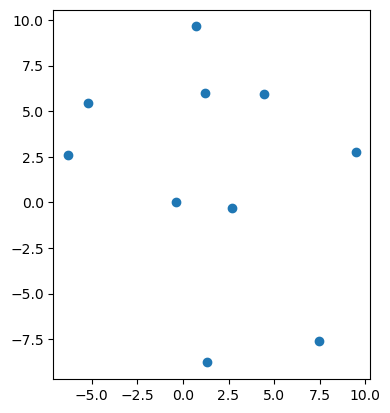

In [190]:
greeted.plot()

In [191]:
mobile_model.step()

using openai gpt-3.5-turbo
p0: Watch a Marvel movie.
p1: Create an arts and crafts project.
p2: Read a Harry Potter book.
p3: Go on a hike with family.
p4: Draw a new character for their story.
p5: Write a new article for their blog.
p6: Cook a delicious meal and share with friends.
p7: Play outdoors and pretend with friends.
p8: Conduct a science experiment with friends.
p9: Go for a nature walk and discover new places.
Watch a Marvel movie.



C:\Users\sky\.conda\envs\abm\lib\site-packages\transformers\pipelines\base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


THE ACTORS ARE: 
['p1', 'p0']
Create an arts and crafts project.

No social interaction for this person!
Read a Harry Potter book.

No social interaction for this person!
Go on a hike with family.

THE ACTORS ARE: 
['p3', 'p4', 'p5']
Draw a new character for their story.

No social interaction for this person!
Write a new article for their blog.

No social interaction for this person!
Cook a delicious meal and share with friends.

THE ACTORS ARE: 
['p7', 'p7', 'p6', 'p6']
Play outdoors and pretend with friends.

THE ACTORS ARE: 
['p9', 'p7']
Conduct a science experiment with friends.

THE ACTORS ARE: 
[]
Go for a nature walk and discover new places.
THE ACTORS ARE: 
['p10', 'p9']
DOING ROOM THINGS!
Hi! Fellow agent p1. I am p0
Hi! Fellow agent p2. I am p0
Hi! Fellow agent p0. I am p1
Hi! Fellow agent p2. I am p1
Hi! Fellow agent p0. I am p2
Hi! Fellow agent p1. I am p2
Hi! Fellow agent p4. I am p3
Hi! Fellow agent p5. I am p3
Hi! Fellow agent p3. I am p4
Hi! Fellow agent p5. I am p4
Hi

<Axes: >

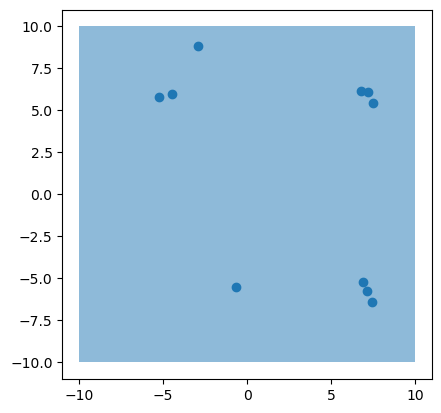

In [192]:
agents = mobile_model.schedule.agents
basemap = gpd.GeoSeries(agents[0].geometry).plot(alpha=0.5)
greeted = gpd.GeoSeries(map(lambda a: a.geometry, [agent for agent in agents if agent.unique_id[0] == "p"]))
greeted.plot(ax=basemap)

p0: p0 will engage in conversations and share travel experiences.
p1: p1 will dance, play video games, and chat with others.
p2: p2 will read books, play video games, and interact with p1.
p3: p3 will discuss books, music, and coding with the group.